# Exploratory Data Analysis

In [3]:
import pandas as pd
from pathlib import Path

In [4]:
DATASET_ROOT = Path("D:\Datasets\Chromatin Loops")

In [5]:
import pickle
genome_file = DATASET_ROOT / 'hg38-003.pkl'
with genome_file.open('rb') as f:
    genome = pickle.load(f)

In [302]:
chrom_lengths = dict()
for chrom, seq in genome.items():
    if '_' not in chrom:
        print(f"{chrom}: {len(seq)}")
        chrom_lengths[chrom] = len(seq)

chr1: 248956422
chr10: 133797422
chr11: 135086622
chr12: 133275309
chr13: 114364328
chr14: 107043718
chr15: 101991189
chr16: 90338345
chr17: 83257441
chr18: 80373285
chr19: 58617616
chr2: 242193529
chr20: 64444167
chr21: 46709983
chr22: 50818468
chr3: 198295559
chr4: 190214555
chr5: 181538259
chr6: 170805979
chr7: 159345973
chr8: 145138636
chr9: 138394717
chrM: 16569
chrX: 156040895
chrY: 57227415


## LoopDB

In [86]:
loopdb_cols = [
    'left_chrom',
    'left_start',
    'left_end',
    'right_chrom',
    'right_start',
    'right_end'
]

bed_cols = [
    'chrom',
    'chromStart',
    'chromEnd',
    'name',
    'score',
    'strand',
    'thickStart',
    'thickEnd',
    'itemRgb',
    'blockCount'
]

In [28]:
loopdb = pd.read_csv('DeepMILO/program/loopDB/all_insulator_loop.bed', sep='\t', header=None, usecols=[0, 1, 2, 5, 6, 7], names=loopdb_cols)

In [29]:
loopdb

,left_chrom,left_start,left_end,right_chrom,right_start,right_end
0,chr1,803273,807273,chr1,1225118,1229118
1,chr1,838274,842274,chr1,871794,875794
2,chr1,838274,842274,chr1,873320,877320
3,chr1,838274,842274,chr1,909668,913668
4,chr1,838274,842274,chr1,917936,921936
...,...,...,...,...,...,...
74475,chrX,154207210,154211210,chrX,154313478,154317478
74476,chrX,154207210,154211210,chrX,154363989,154367989
74477,chrX,154207210,154211210,chrX,154375433,154379433
74478,chrX,154207210,154211210,chrX,154405984,154409984


In [135]:
loop_boundaries = []
for i, row in loopdb.iterrows():
    left = Boundary(row['left_chrom'], row['left_start'], row['left_end'])
    right = Boundary(row['right_chrom'], row['right_start'], row['right_end'])
    loop_boundaries.append(left)
    loop_boundaries.append(right)

In [136]:
len(loop_boundaries)

148960

In [137]:
loop_boundaries_dedupe = merge_overlap_region(loop_boundaries)

In [138]:
len(loop_boundaries_dedupe)

33762

In [237]:
loop_boundaries_df = regions_to_df(loop_boundaries_dedupe)

In [238]:
loop_boundaries_df.to_csv('loop_boundaries.csv')

## CTCF Motifs

In [154]:
allcomp_file = DATASET_ROOT / 'CTCFBSDB' / 'allcomp.txt'
allcomp = pd.read_csv(allcomp_file, sep='\t')

In [155]:
allcomp_location = allcomp['Chromosome Location'].str.replace('_random', '').str.extract(r'(?P<chrom>chr.*?):(?P<start>\d+)-(?P<end>\d+)')
allcomp = pd.concat([allcomp, allcomp_location], axis=1)
allcomp = allcomp[allcomp['Species'] == 'Human']

In [156]:
allcomp

,ID,Species,Chromosome Location,5' Flanking Gene,3' Flanking Gene,chrom,start,end
0,INSUL_PRE00001,Human,chr1:100276250-100276269,SLC35A3,HIAT1,chr1,100276250,100276269
1,INSUL_PRE00002,Human,chr1:101106697-101106716,-,EXTL2,chr1,101106697,101106716
2,INSUL_PRE00003,Human,chr1:101159421-101159440,EXTL2,SLC30A7,chr1,101159421,101159440
3,INSUL_PRE00004,Human,chr1:101442377-101442396,-,EDG1,chr1,101442377,101442396
4,INSUL_PRE00005,Human,chr1:101526743-101526762,EDG1,-,chr1,101526743,101526762
...,...,...,...,...,...,...,...,...
18900,INSUL_PRE18901,Human,chr1:67450055-67450073,C1orf141,IL23R,chr1,67450055,67450073
18901,INSUL_PRE18902,Human,chr1:29435528-29435546,MECR,PTPRU,chr1,29435528,29435546
18902,INSUL_PRE18903,Human,chr1:219982850-219982868,DUSP10,-,chr1,219982850,219982868
18903,INSUL_PRE18904,Human,chr1:178600988-178601005,AK096250,ACBD6,chr1,178600988,178601005


In [157]:
allcomp_regions = []
for i, row in allcomp.iterrows():
    region = Boundary(row['chrom'], row['start'], row['end'])
    allcomp_regions.append(region)

In [158]:
len(allcomp_regions)

13401

In [159]:
allcomp_regions_dedupe = merge_overlap_region(allcomp_regions)

In [160]:
len(allcomp_regions_dedupe)

13348

In [147]:
allexp_file = DATASET_ROOT / 'CTCFBSDB' / 'allexp.txt'
allexp = pd.read_csv(allexp_file, sep='\t')
allexp = allexp[allexp['Species'] == 'Human']

In [148]:
allexp_location = allexp['chromosome Location'].str.replace('_random', '').str.extract(r'(?P<chrom>chr.*?):(?P<start>\d+)-(?P<end>\d+)')
allexp = pd.concat([allexp, allexp_location], axis=1)

In [149]:
allexp

,ID,Species,Name,chromosome Location,5' Flanking Gene,3' Flanking Gene,Validation Method,In Situ Function,Description,Reference,chrom,start,end
0,INSUL_MAN00001,Human,GTL2-a,chr14:100364027-100364047,DLK1,FP504,sequence analysis,NaN,imprinting,11076856,chr14,100364027,100364047
1,INSUL_MAN00002,Human,GTL2-b,chr14:100364319-100364339,DLK1,FP504,sequence analysis,NaN,imprinting,11076856,chr14,100364319,100364339
2,INSUL_MAN00003,Human,apoB CTCF,chr2:21174437-21174468,APOB,-,in vitro binding;enhancer-blocking assay,chromatin boundary,NaN,11389587,chr2,21174437,21174468
3,INSUL_MAN00004,Human,DM1 site 1,chr19:50965398-50965458,SIX5,DMPK,in vitro binding;in vivo binding,enhancer-blocking,CTG/CAG repeats;methylation-sensitive,11479593,chr19,50965398,50965458
4,INSUL_MAN00005,Human,DM1 site 2,chr19:50965141-50965201,SIX5,DMPK,in vitro binding;in vivo binding,enhancer-blocking,CTG/CAG repeats;methylation-sensitive,11479593,chr19,50965141,50965201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34412,INSUL_ZHAO20258,Human,NaN,chrY:57388212-57389010,-,-,in vivo binding,NaN,high throughput,17512414,chrY,57388212,57389010
34413,INSUL_ZHAO20259,Human,NaN,chrY:57389812-57393410,-,-,in vivo binding,NaN,high throughput,17512414,chrY,57389812,57393410
34414,INSUL_ZHAO20260,Human,NaN,chrY:57393812-57399010,-,-,in vivo binding,NaN,high throughput,17512414,chrY,57393812,57399010
34415,INSUL_ZHAO20261,Human,NaN,chrY:57399412-57403810,-,-,in vivo binding,NaN,high throughput,17512414,chrY,57399412,57403810


In [152]:
allexp_regions = []
for i, row in allexp.iterrows():
    region = Boundary(row['chrom'], row['start'], row['end'])
    allexp_regions.append(region)

In [161]:
len(allexp_regions)

34117

In [162]:
allexp_regions_dedupe = merge_overlap_region(allexp_regions)

In [163]:
len(allexp_regions_dedupe)

26407

### FIMO

In [176]:
fimo_file = DATASET_ROOT / 'FIMO2' / 'fimo.tsv'
fimo = pd.read_csv(fimo_file, sep='\t')[:-3]

In [177]:
fimo = fimo[fimo['p-value'] < 0.00005]

In [184]:
fimo['start'] = fimo['start'].astype('int')
fimo['stop'] = fimo['stop'].astype('int')

In [185]:
fimo

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr7,98021694,98021712,+,28.7531,1.740000e-13,0.000398,CGGCCACCAGGGGGCGCCG
1,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr22,30387500,30387518,-,28.5309,3.470000e-13,0.000398,CGGCCACCAGGGGGCGCCC
2,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr16,67993403,67993421,+,28.5309,3.470000e-13,0.000398,CGGCCACCAGGGGGCGCCC
3,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr12,108618283,108618301,-,28.5309,3.470000e-13,0.000398,CGGCCACCAGGGGGCGCCC
4,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr12,121500063,121500081,+,28.5309,3.470000e-13,0.000398,CGGCCACCAGGGGGCGCCC
...,...,...,...,...,...,...,...,...,...,...
53333,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr2,216605676,216605694,+,16.0864,1.510000e-06,0.170000,gggccaccagaaggagggg
53334,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr1,223756189,223756207,+,16.0864,1.510000e-06,0.170000,CCACAGCCAGAGGGCAGCC
53335,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr2,224646383,224646401,+,16.0864,1.510000e-06,0.170000,ccaccaccaggggacattc
53336,CTCF_HUMAN.H11MO.0.A,BBDCCRSYAGGKGGCRSBV,chr2,236503269,236503287,+,16.0864,1.510000e-06,0.170000,CTTCCACCAGGGGGAAACC


In [186]:
fimo_regions = []
for i, row in fimo.iterrows():
    region = Boundary(row['sequence_name'], row['start'], row['stop'])
    fimo_regions.append(region)

In [188]:
len(fimo_regions)

53338

In [187]:
fimo_regions_dedupe = merge_overlap_region(fimo_regions)

In [189]:
len(fimo_regions_dedupe)

52993

## ChIP-seq

In [92]:
chipseq_download = {
    'K562': 'https://www.encodeproject.org/files/ENCFF736NYC/@@download/ENCFF736NYC.bed.gz',
    'MCF-7': 'https://www.encodeproject.org/files/ENCFF948CYD/@@download/ENCFF948CYD.bed.gz',
    'GM12878': 'https://www.encodeproject.org/files/ENCFF951PEM/@@download/ENCFF951PEM.bed.gz',
    'HeLa': 'https://www.encodeproject.org/files/ENCFF030QAM/@@download/ENCFF030QAM.bed.gz'
}

In [100]:
chipseq_lines = dict()
for cell_line in chipseq_download.keys():
    chipseq_file = DATASET_ROOT / "ChIP-seq" / f"{cell_line}_ChIP-seq.bed"
    chip = pd.read_csv(chipseq_file, sep='\t', header=None, names=bed_cols)
    chipseq_lines[cell_line] = chip

In [101]:
chipseq_lines['K562']

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr22,20564308,20564696,.,1000,.,571.91438,-1.0,4.89554,193
1,chr22,22559101,22559504,.,1000,.,566.78515,-1.0,4.89554,209
2,chr7,151172567,151172908,.,1000,.,513.84869,-1.0,4.89554,168
3,chr22,22060594,22060920,.,1000,.,513.70560,-1.0,4.89554,150
4,chr22,19970490,19970814,.,1000,.,480.82387,-1.0,4.89554,171
...,...,...,...,...,...,...,...,...,...,...
46155,chr10,46398351,46398621,.,697,.,3.43380,-1.0,0.12629,135
46156,chr8,139644828,139645098,.,859,.,3.40436,-1.0,0.11895,135
46157,chr12,54332292,54332562,.,589,.,3.39010,-1.0,0.11875,135
46158,chr12,69649770,69650040,.,833,.,3.37970,-1.0,0.12236,135


In [102]:
chipseq_lines['MCF-7']

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr1,150979489,150979809,.,1000,.,578.47634,-1.0,4.95512,172
1,chr20,58209843,58210168,.,1000,.,568.35187,-1.0,4.95512,184
2,chr20,48620991,48621348,.,1000,.,558.61862,-1.0,4.95512,194
3,chr17,57243135,57243455,.,1000,.,556.09106,-1.0,4.95512,153
4,chr20,48189241,48189524,.,1000,.,540.63845,-1.0,4.95512,143
...,...,...,...,...,...,...,...,...,...,...
63359,chr20,61355906,61356182,.,978,.,5.20864,-1.0,0.06161,138
63360,chr11,9204173,9204449,.,916,.,5.20782,-1.0,0.06101,138
63361,chr16,12815625,12815901,.,804,.,5.18136,-1.0,0.05624,138
63362,chr11,111932022,111932298,.,1000,.,5.15634,-1.0,0.05409,138


In [103]:
chipseq_lines['GM12878']

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr14,21092523,21092812,.,1000,.,408.08525,-1.0,4.84507,152
1,chr10,75235958,75236239,.,1000,.,380.90346,-1.0,4.84507,138
2,chr14,106417526,106417988,.,1000,.,380.24830,-1.0,4.84507,243
3,chr6,53171888,53172181,.,1000,.,370.72262,-1.0,4.84507,157
4,chr14,49862084,49862350,.,1000,.,370.35115,-1.0,4.84507,129
...,...,...,...,...,...,...,...,...,...,...
42376,chr14,74290198,74290448,.,1000,.,3.20834,-1.0,-0.04810,125
42377,chr8,129406752,129407002,.,581,.,3.17488,-1.0,-0.04322,125
42378,chr8,30658155,30658405,.,678,.,3.13443,-1.0,-0.07241,125
42379,chr13,33016851,33017101,.,791,.,3.12650,-1.0,-0.07931,125


In [104]:
chipseq_lines['HeLa']

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount
0,chr12,54379677,54379967,.,1000,.,477.53716,-1.0,4.93774,149
1,chr1,114346524,114346847,.,1000,.,459.07589,-1.0,4.93774,172
2,chr5,43105720,43106025,.,1000,.,456.56290,-1.0,4.93774,152
3,chr11,47355250,47355552,.,1000,.,445.39895,-1.0,4.93774,152
4,chr1,109263623,109264013,.,1000,.,440.12649,-1.0,4.93774,165
...,...,...,...,...,...,...,...,...,...,...
41922,chr9,20552977,20553227,.,548,.,2.65803,-1.0,0.47149,125
41923,chr8,57182440,57182690,.,590,.,2.61845,-1.0,0.46443,125
41924,chr1,154405179,154405429,.,1000,.,2.51297,-1.0,0.32174,125
41925,chr21,38806471,38806721,.,927,.,2.47261,-1.0,0.30423,125


In [105]:
chipseq = pd.concat(chipseq_lines.values())

In [109]:
chipseq['chrom'].value_counts()

chr1     18703
chr2     14486
chr3     12263
chr5     10505
chr7     10460
chr6     10428
chr11    10142
chr12     9743
chr17     9131
chr10     8889
chr8      8780
chr4      8424
chr9      8052
chr19     7585
chr16     6870
chr15     6540
chr14     6493
chrX      6394
chr20     6176
chr13     4033
chr18     3793
chr22     3742
chr21     2200
Name: chrom, dtype: int64

In [112]:
from matplotlib import pyplot as plt

(array([1.5563e+04, 2.7249e+04, 7.6207e+04, 7.4675e+04, 9.6000e+01,
        2.6000e+01, 5.0000e+00, 5.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([ 62. , 125.5, 189. , 252.5, 316. , 379.5, 443. , 506.5, 570. ,
        633.5, 697. ]),
 <BarContainer object of 10 artists>)

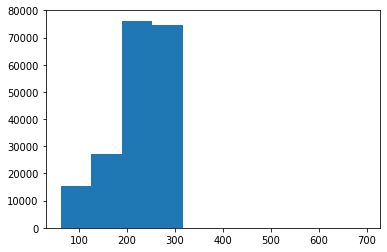

In [117]:
chipseq_lengths = chipseq['chromEnd'] - chipseq['chromStart']
chipseq['lengths'] = chipseq_lengths
plt.hist(chipseq_lengths)

In [118]:
chipseq_midpoints = (chipseq['chromEnd'] + chipseq['chromStart'])/2
chipseq['midpoint'] = chipseq_midpoints

In [122]:
import sys

sys.path.append("DeepMILO/source")

In [126]:
from common_object import *
from common_function import merge_overlap_region

In [131]:
chipseq_regions = []
for i, row in chipseq.iterrows():
    region = Boundary(row['chrom'], row['chromStart'], row['chromEnd'])
    chipseq_regions.append(region)

In [132]:
len(chipseq_regions)

193832

In [133]:
chipseq_regions_dedupe = merge_overlap_region(chipseq_regions)

In [169]:
len(chipseq_regions_dedupe)

77722

## Non-Anchor Datasets

In [166]:
REGION_SIZE = 4000

In [165]:
def is_overlap(reg1, reg2, overlap_rate=0.5):
    overlap_len = reg1.overlap(reg2)

    reg_len = min(reg1.end - reg1.start, reg2.end - reg2.start)

    maxend = max(reg1.end, reg2.end)
    minstart = min(reg1.start, reg2.start)
    
    if overlap_len < reg_len * overlap_rate or maxend - minstart > REGION_SIZE * 1.5:
        return False
    else:
        return True

In [195]:
def exclude_overlap(source, reference):
    s = sorted(source, key=lambda x: (x.chrid, x.start, x.end))
    r = sorted(reference, key=lambda x: (x.chrid, x.start, x.end))  
    i = 0
    unique_regions = []
    
    for j in range(len(s)):
        valid = True
        while i < len(r) and r[i].start < s[j].end:
            if is_overlap(s[j], r[i]):
                valid = False
                break
            i += 1
        i -= 1
        
        if valid:
            unique_regions.append(s[j])
    
    return unique_regions

In [196]:
non_anchor_type1 = exclude_overlap(chipseq_regions_dedupe, loop_boundaries_dedupe)

In [197]:
len(non_anchor_type1)

77484

In [228]:
non_anchor_type1_df = regions_to_df(non_anchor_type1)

In [230]:
non_anchor_type1_df

,chrom,start,end
0,chr1,16103,16353
1,chr1,138683,138953
2,chr1,138883,139153
3,chr1,267865,268141
4,chr1,586050,586327
...,...,...,...
77479,chrX,155864713,155864989
77480,chrX,155938163,155938439
77481,chrX,155955666,155955936
77482,chrX,155966949,155967219


In [232]:
non_anchor_type1_df.to_csv('non_anchor_type_1.csv')

In [198]:
ctcf_motif_no_anchor = exclude_overlap(fimo_regions_dedupe, loop_boundaries_dedupe)
non_anchor_type2 = exclude_overlap(ctcf_motif_no_anchor, non_anchor_type1)

In [199]:
len(non_anchor_type2)

51504

In [229]:
non_anchor_type2_df = regions_to_df(non_anchor_type2)

In [231]:
non_anchor_type2_df

,chrom,start,end
0,chr19_KI270868v1_alt,15,33
1,chrUn_GL000195v1,91,109
2,chr5_KI270792v1_alt,208,226
3,chr15_KI270848v1_alt,277,295
4,chr20_KI270869v1_alt,1058,1076
...,...,...,...
51499,chrY,57044316,57044334
51500,chrY,57203409,57203427
51501,chrY,57215220,57215238
51502,chrY,57215279,57215297


In [233]:
non_anchor_type2_df.to_csv('non_anchor_type_2.csv')

In [219]:
chromosomes = [str(x) for x in range(1, 23)] + ['X', 'Y']
print(chromosomes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']


In [203]:
chipseq_min = min([x.start for x in chipseq_regions_dedupe])
chipseq_max = max([x.end for x in chipseq_regions_dedupe])

In [204]:
loop_min = min([x.start for x in loop_boundaries_dedupe])
loop_max = max([x.end for x in loop_boundaries_dedupe])

In [205]:
fimo_min = min([x.start for x in fimo_regions_dedupe])
fimo_max = max([x.end for x in fimo_regions_dedupe])

In [208]:
MAX_BASE = max(chipseq_max, loop_max, fimo_max)
print(MAX_BASE)

249221216


In [210]:
import random

In [212]:
random.randint(0, MAX_BASE)

125146623

In [304]:
negative_regions = []
for i in range(100000):
    chrom = random.choice(chromosomes)
    start = random.randint(0, chrom_lengths['chr' + chrom]-5000)
    
    region = Boundary(chrom, start, start+REGION_SIZE)
    negative_regions.append(region)

In [305]:
non_anchor_type3 = exclude_overlap(negative_regions, loop_boundaries_dedupe)
non_anchor_type3 = exclude_overlap(non_anchor_type3, non_anchor_type1)
non_anchor_type3 = exclude_overlap(non_anchor_type3, non_anchor_type2)

In [306]:
len(non_anchor_type3)

99418

In [226]:
def regions_to_df(regions):
    return pd.DataFrame([{'chrom': r.chrom, 'start': r.start, 'end': r.end} for r in regions])

In [307]:
non_anchor_type3_df = regions_to_df(non_anchor_type3)

In [308]:
non_anchor_type3_df.to_csv('non_anchor_type_3.csv')

## Master Dataset

In [14]:
loop_boundaries_df = pd.read_csv('loop_boundaries.csv', index_col=0)
non_anchor_type1_df = pd.read_csv('non_anchor_type_1.csv', index_col=0)
non_anchor_type2_df = pd.read_csv('non_anchor_type_2.csv', index_col=0)
non_anchor_type3_df = pd.read_csv('non_anchor_type_3.csv', index_col=0)

In [17]:
loop_boundaries_df['anchor'] = 1

In [18]:
loop_boundaries_df

,chrom,start,end,anchor
0,chr1,803273,807273,1
1,chr1,838274,842274,1
2,chr1,871794,877320,1
3,chr1,909668,913668,1
4,chr1,917936,921936,1
...,...,...,...,...
33757,chrX,154284034,154288034,1
33758,chrX,154313478,154317478,1
33759,chrX,154363989,154367989,1
33760,chrX,154375433,154379433,1


In [19]:
non_anchor_type1_df['anchor'] = 0
non_anchor_type1_df

,chrom,start,end,anchor
0,chr1,16103,16353,0
1,chr1,138683,138953,0
2,chr1,138883,139153,0
3,chr1,267865,268141,0
4,chr1,586050,586327,0
...,...,...,...,...
77479,chrX,155864713,155864989,0
77480,chrX,155938163,155938439,0
77481,chrX,155955666,155955936,0
77482,chrX,155966949,155967219,0


In [21]:
non_anchor_type2_df['anchor'] = 0
non_anchor_type2_df

,chrom,start,end,anchor
0,chr19_KI270868v1_alt,15,33,0
1,chrUn_GL000195v1,91,109,0
2,chr5_KI270792v1_alt,208,226,0
3,chr15_KI270848v1_alt,277,295,0
4,chr20_KI270869v1_alt,1058,1076,0
...,...,...,...,...
51499,chrY,57044316,57044334,0
51500,chrY,57203409,57203427,0
51501,chrY,57215220,57215238,0
51502,chrY,57215279,57215297,0


In [22]:
non_anchor_type3_df['anchor'] = 0
non_anchor_type3_df

,chrom,start,end,anchor
0,chr1,34994,38994,0
1,chr1,140402,144402,0
2,chr1,171561,175561,0
3,chr1,199145,203145,0
4,chr1,323469,327469,0
...,...,...,...,...
99413,chrY,57127594,57131594,0
99414,chrY,57137528,57141528,0
99415,chrY,57142260,57146260,0
99416,chrY,57148670,57152670,0


In [23]:
loop_boundaries_train = loop_boundaries_df[~loop_boundaries_df['chrom'].isin(['chr7', 'chr8', 'chr16'])].sample(29000)
loop_boundaries_test = loop_boundaries_df[loop_boundaries_df['chrom'].isin(['chr7', 'chr8'])].sample(3000)
loop_boundaries_val = loop_boundaries_df[loop_boundaries_df['chrom'].isin(['chr16'])].sample(1000)

In [24]:
loop_boundaries_train

,chrom,start,end,anchor
21160,chr11,126260165,126264165,1
7138,chr3,127812310,127816310,1
32125,chr22,21981895,21985895,1
27254,chr17,4633544,4637544,1
12346,chr6,86883220,86887220,1
...,...,...,...,...
11507,chr6,14128026,14132026,1
25704,chr15,79216654,79220654,1
19710,chr11,16965741,16969741,1
4500,chr2,109742618,109746618,1


In [25]:
loop_boundaries_test

,chrom,start,end,anchor
16263,chr8,135695883,135699883,1
13665,chr7,37547648,37551648,1
15599,chr8,72730268,72734268,1
13650,chr7,36478697,36482697,1
14432,chr7,122846716,122850716,1
...,...,...,...,...
14676,chr7,141673627,141677627,1
15755,chr8,91655446,91659446,1
15307,chr8,38643173,38647173,1
15738,chr8,90082204,90086204,1


In [26]:
loop_boundaries_val

,chrom,start,end,anchor
26667,chr16,58037225,58041225,1
26932,chr16,79789237,79793237,1
26466,chr16,29816802,29820802,1
26188,chr16,8615593,8619593,1
26102,chr16,2243065,2247065,1
...,...,...,...,...
27128,chr16,88802036,88806036,1
27095,chr16,87603269,87607269,1
26605,chr16,53924360,53928360,1
26221,chr16,10760501,10764501,1


In [37]:
non_anchor_type1_train = non_anchor_type1_df[~non_anchor_type1_df['chrom'].isin(['chr7', 'chr8', 'chr16'])].sample(int(0.5*29000))
non_anchor_type1_test = non_anchor_type1_df[non_anchor_type1_df['chrom'].isin(['chr7', 'chr8'])].sample(int(0.5*3000))
non_anchor_type1_val = non_anchor_type1_df[non_anchor_type1_df['chrom'].isin(['chr16'])].sample(int(0.5*1000))

In [38]:
non_anchor_type1_train

,chrom,start,end,anchor
47548,chr11,96155923,96156193,0
11340,chr2,176638203,176638490,0
23086,chr5,72109697,72109973,0
23652,chr5,99060454,99060609,0
45036,chr11,8192644,8192849,0
...,...,...,...,...
18626,chr4,15955717,15955997,0
67257,chr19,4374727,4374997,0
15844,chr3,121940748,121941024,0
3273,chr1,94240890,94241166,0


In [39]:
non_anchor_type1_test

,chrom,start,end,anchor
34441,chr8,10593068,10593338,0
33668,chr7,142445081,142445351,0
37399,chr8,132192090,132192305,0
30249,chr7,5302611,5302916,0
33201,chr7,128381190,128381440,0
...,...,...,...,...
37873,chr8,144684255,144684575,0
33459,chr7,135335719,135335991,0
30288,chr7,6106454,6106750,0
33264,chr7,129502810,129503060,0


In [40]:
non_anchor_type1_val

,chrom,start,end,anchor
59319,chr16,1564360,1564648,0
59751,chr16,12308094,12308370,0
59432,chr16,2961777,2962024,0
59802,chr16,14289793,14290043,0
61504,chr16,84084850,84085070,0
...,...,...,...,...
61717,chr16,87456975,87457225,0
59422,chr16,2874908,2875149,0
60698,chr16,57627481,57627731,0
61586,chr16,85363589,85363865,0


In [41]:
non_anchor_type2_train = non_anchor_type2_df[~non_anchor_type2_df['chrom'].isin(['chr7', 'chr8', 'chr16'])].sample(int(0.3*29000))
non_anchor_type2_test = non_anchor_type2_df[non_anchor_type2_df['chrom'].isin(['chr7', 'chr8'])].sample(int(0.3*3000))
non_anchor_type2_val = non_anchor_type2_df[non_anchor_type2_df['chrom'].isin(['chr16'])].sample(int(0.3*1000))

In [42]:
non_anchor_type2_train

,chrom,start,end,anchor
3469,chr1,396125,396143,0
50336,chrX,17654395,17654413,0
34373,chr14,22865665,22865683,0
35614,chr14,104475950,104475968,0
16748,chr5,175729972,175729990,0
...,...,...,...,...
10995,chr3,45929230,45929248,0
28848,chr11,9893741,9893759,0
49885,chr22,46797628,46797646,0
8062,chr2,74139146,74139164,0


In [43]:
non_anchor_type2_test

,chrom,start,end,anchor
20962,chr7,105552505,105552523,0
19916,chr7,36473544,36473562,0
20171,chr7,50513859,50513877,0
20509,chr7,73328275,73328293,0
22770,chr8,63250272,63250290,0
...,...,...,...,...
22130,chr8,16764555,16764573,0
22368,chr8,29347765,29347783,0
20847,chr7,100693679,100693697,0
23444,chr8,134720643,134720661,0


In [44]:
non_anchor_type2_val

,chrom,start,end,anchor
39362,chr16,67185562,67185580,0
38314,chr16,9092419,9092437,0
38773,chr16,30530806,30530824,0
38011,chr16,1626675,1626693,0
39936,chr16,88060600,88060618,0
...,...,...,...,...
38790,chr16,30829882,30829900,0
38912,chr16,32982939,32982957,0
37844,chr16,374335,374353,0
38229,chr16,4616560,4616578,0


In [45]:
non_anchor_type3_train = non_anchor_type3_df[~non_anchor_type3_df['chrom'].isin(['chr7', 'chr8', 'chr16'])].sample(int(0.2*29000))
non_anchor_type3_test = non_anchor_type3_df[non_anchor_type3_df['chrom'].isin(['chr7', 'chr8'])].sample(int(0.2*3000))
non_anchor_type3_val = non_anchor_type3_df[non_anchor_type3_df['chrom'].isin(['chr16'])].sample(int(0.2*1000))

In [46]:
non_anchor_type3_train

,chrom,start,end,anchor
4992,chr2,79143483,79147483,0
83315,chr21,5095269,5099269,0
14599,chr4,122270529,122274529,0
74470,chr18,78046385,78050385,0
83746,chr21,9814726,9818726,0
...,...,...,...,...
40841,chr10,119606043,119610043,0
60219,chr15,52669877,52673877,0
18523,chr5,106392271,106396271,0
90466,chr22,42569501,42573501,0


In [47]:
non_anchor_type3_test

,chrom,start,end,anchor
25397,chr7,32445342,32449342,0
28106,chr7,135891416,135895416,0
27107,chr7,98305979,98309979,0
24806,chr7,11351078,11355078,0
31243,chr8,89421488,89425488,0
...,...,...,...,...
29598,chr8,31478942,31482942,0
29101,chr8,14302968,14306968,0
25657,chr7,42974157,42978157,0
25915,chr7,52104594,52108594,0


In [48]:
non_anchor_type3_val

,chrom,start,end,anchor
62555,chr16,8072581,8076581,0
62961,chr16,17040401,17044401,0
65529,chr16,74077470,74081470,0
63736,chr16,33673954,33677954,0
64024,chr16,39639592,39643592,0
...,...,...,...,...
62729,chr16,11975855,11979855,0
62385,chr16,4507337,4511337,0
63277,chr16,23988050,23992050,0
62987,chr16,17741038,17745038,0


In [49]:
master_train = pd.concat([loop_boundaries_train, non_anchor_type1_train, non_anchor_type2_train, non_anchor_type3_train])
master_test = pd.concat([loop_boundaries_test, non_anchor_type1_test, non_anchor_type2_test, non_anchor_type3_test])
master_val = pd.concat([loop_boundaries_val, non_anchor_type1_val, non_anchor_type2_val, non_anchor_type3_val])

In [50]:
master_train

,chrom,start,end,anchor
21160,chr11,126260165,126264165,1
7138,chr3,127812310,127816310,1
32125,chr22,21981895,21985895,1
27254,chr17,4633544,4637544,1
12346,chr6,86883220,86887220,1
...,...,...,...,...
40841,chr10,119606043,119610043,0
60219,chr15,52669877,52673877,0
18523,chr5,106392271,106396271,0
90466,chr22,42569501,42573501,0


In [51]:
master_test

,chrom,start,end,anchor
16263,chr8,135695883,135699883,1
13665,chr7,37547648,37551648,1
15599,chr8,72730268,72734268,1
13650,chr7,36478697,36482697,1
14432,chr7,122846716,122850716,1
...,...,...,...,...
29598,chr8,31478942,31482942,0
29101,chr8,14302968,14306968,0
25657,chr7,42974157,42978157,0
25915,chr7,52104594,52108594,0


In [52]:
master_val

,chrom,start,end,anchor
26667,chr16,58037225,58041225,1
26932,chr16,79789237,79793237,1
26466,chr16,29816802,29820802,1
26188,chr16,8615593,8619593,1
26102,chr16,2243065,2247065,1
...,...,...,...,...
62729,chr16,11975855,11979855,0
62385,chr16,4507337,4511337,0
63277,chr16,23988050,23992050,0
62987,chr16,17741038,17745038,0


In [53]:
master_dataset_size = len(master_train) + len(master_test) + len(master_val)

In [54]:
print(f"Training set size: {len(master_train)} ({len(master_train) / master_dataset_size:.2%})")
print(f"Test set size: {len(master_test)} ({len(master_test) / master_dataset_size:.2%})")
print(f"Validation set size: {len(master_val)} ({len(master_val) / master_dataset_size:.2%})")

Training set size: 58000 (87.88%)
Test set size: 6000 (9.09%)
Validation set size: 2000 (3.03%)


In [55]:
master_train.to_csv('anchor_datasets/anchor_master_train.csv')
master_test.to_csv('anchor_datasets/anchor_master_test.csv')
master_val.to_csv('anchor_datasets/anchor_master_val.csv')

In [325]:
train_out_of_range = []
for i, row in master_train.iterrows():
    if row['chrom'] in chrom_lengths and row['start'] > chrom_lengths[row['chrom']]:
        train_out_of_range.append(row)
len(train_out_of_range)

185

In [326]:
test_out_of_range = []
for i, row in master_test.iterrows():
    if row['chrom'] in chrom_lengths and row['start'] > chrom_lengths[row['chrom']]:
        test_out_of_range.append(row)
len(test_out_of_range)

30

In [327]:
val_out_of_range = []
for i, row in master_val.iterrows():
    if row['chrom'] in chrom_lengths and row['start'] > chrom_lengths[row['chrom']]:
        val_out_of_range.append(row)
len(val_out_of_range)

0

In [12]:
master_train = pd.read_csv('anchor_datasets/anchor_master_train.csv', index_col=0)

In [13]:
master_train

,chrom,start,end,anchor
22021,chr12,54686154,54690154,1.0
9664,chr5,32470089,32474089,1.0
11985,chr6,42035500,42039500,1.0
28325,chr17,62933100,62937100,1.0
1887,chr1,153371013,153375013,1.0
...,...,...,...,...
17644,chr5,68465785,68469785,NaN
77536,chr19,40399162,40403162,NaN
48630,chr12,104802620,104806620,NaN
87651,chr22,7802138,7806138,NaN
